In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [3]:
import os

In [27]:
import numpy as np
from functools import partial
from tqdm.autonotebook import tqdm

In [22]:
from chequeparser.datasets import FileDS, ImageDS
from chequeparser.wrappers import (
    DetectionResults,
    BBox,
)

Reloading 'chequeparser.wrappers'.
Reloading 'chequeparser.core.recognizer'.


In [25]:
from chequeparser.wrappers.io import (
    save_dets, load_dets, save_dets_as_label_studio
)

from chequeparser.datasets.io import load_yolo

In [45]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection import UltralyticsDetect, DoctrDetect
from chequeparser.models.recognition import DoctrRecognize
from chequeparser.core import detect, recognize
from chequeparser.utilities import (
    concat_ds, get_samples, convert_tif_to_jpg
)

Reloading 'chequeparser.utilities.io_utils'.
Reloading 'chequeparser.utilities'.
Reloading 'chequeparser.datasets.imageds'.
Reloading 'chequeparser.wrappers.recognition_results'.
Reloading 'chequeparser.wrappers.detection_results'.
Reloading 'chequeparser.wrappers.io'.
Reloading 'chequeparser.datasets.base'.


In [7]:
import pkg_resources
from symspellpy import SymSpell

In [8]:
from itertools import product

## config

In [28]:
dir_images = "../data/public/images/"
dir_sav = "temp/"
f_dataset_yml = "../data/public/dataset.yml"
f_roi_dets_sav = os.path.join(dir_sav, "roi_dets.h5")
f_words_dets_sav = os.path.join(dir_sav, "words_dets.h5")
f_gcv_dets_sav = os.path.join(dir_sav, "gcv_dets.h5")
f_true_anchor_dets_sav = os.path.join(dir_sav, "true_anchor_dets.h5")
f_bkp_anchor_dets_sav = os.path.join(dir_sav, "bkp_anchor_dets.h5")
f_bkp2_anchor_dets_sav = os.path.join(dir_sav, "bkp2_anchor_dets.h5")
f_true_payee_dets_sav = os.path.join(dir_sav, "true_payee_dets.h5")
f_false_payee_dets_sav = os.path.join(dir_sav, "false_payee_dets.h5")

## load ds

In [29]:
all_ds = FileDS(dir_images)

  0%|          | 0/236 [00:00<?, ?it/s]

2024-02-23 13:21:36.569 | INFO     | chequeparser.utilities.io_utils:get_files:41 - Found 235 files.


In [30]:
rand_id = 10

In [33]:
single_ds = all_ds.get_as_ds(rand_id)

Reloading 'chequeparser.datasets.base'.


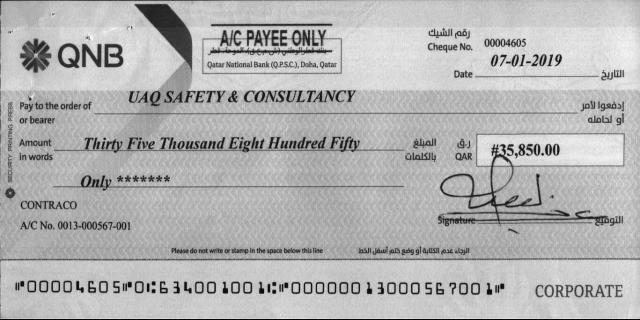

In [34]:
single_ds[0]

## load models

In [36]:
roi_model = UltralyticsDetect(path="../pretrained/best.pt", arch=UL_RTDETR)

In [37]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
words_model = DoctrDetect(path="db_resnet50", 
                          arch=DOCTR_DETECT_PRETRAINED, 
                          arch_config = doctr_det_arch_config)

In [38]:
rec_model = DoctrRecognize(path="crnn_vgg16_bn", arch=DOCTR_RECOG_PRETRAINED)

In [344]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
spell_checker = partial(sym_spell.lookup_compound,
                        max_edit_distance=2, 
                        transfer_casing=True,
                        split_by_space=True,
                        ignore_non_words=True,
                        ignore_term_with_digits=True
                       )
op_spell_check = lambda x: spell_checker(x)[0].term

## run and save model outputs

In [46]:
convert_tif_to_jpg??

Signature:
convert_tif_to_jpg(
    path_tif: pathlib.Path,
    path_jpeg: pathlib.Path,
    ext='.jpg',
)
Docstring: <no docstring>
Source:   
def convert_tif_to_jpg(path_tif: Path, path_jpeg: Path, ext=".jpg"):
    path_jpeg.mkdir(parents=True, exist_ok=True)
    for item in tqdm(list(path_tif.glob("*.tif"))):
        img = Image.open(item).convert("RGB")
        img.save(path_jpeg / Path(item.name).with_suffix(ext))
File:      ~/workspace/chequeparser/src/chequeparser/utilities/io_utils.py
Type:      function

In [324]:
# l_roi_dets = []
# for res in tqdm(detect(roi_model, all_ds, stream=True,
#                        verbose=False),
#               total=len(all_ds)):
#     l_roi_dets.append(res)

  0%|          | 0/4 [00:00<?, ?it/s]

In [40]:
all_ds, l_roi_dets = load_yolo(f_dataset_yml)

  0%|          | 0/236 [00:00<?, ?it/s]

2024-02-23 13:22:55.394 | INFO     | chequeparser.utilities.io_utils:get_files:41 - Found 235 files.
2024-02-23 13:22:55.405 | INFO     | chequeparser.datasets.io:load_yolo:53 - Found 235 valid images out of 235


In [41]:
l_roi_dets[0].to_numpy(encode=True, include_meta=True)

array([[b'39', b'276', b'332', b'302', b'False', b'1.0', b'micr', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'459', b'41', b'609', b'63', b'False', b'1.0', b'date', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'70', b'88', b'112', b'110', b'False', b'1.0', b'payee', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'46', b'95', b'61', b'109', b'False', b'1.0', b'orderof', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'462', b'136', b'508', b'157', b'False', b'1.0', b'amnt', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320']], dtype='|S55')

In [42]:
l_roi_dets[0].to_numpy(encode=True, include_meta=True)

array([[b'39', b'276', b'332', b'302', b'False', b'1.0', b'micr', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'459', b'41', b'609', b'63', b'False', b'1.0', b'date', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'70', b'88', b'112', b'110', b'False', b'1.0', b'payee', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'46', b'95', b'61', b'109', b'False', b'1.0', b'orderof', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320'],
       [b'462', b'136', b'508', b'157', b'False', b'1.0', b'amnt', b'', b'0', b'0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d27214.jpg', b'640', b'320']], dtype='|S55')

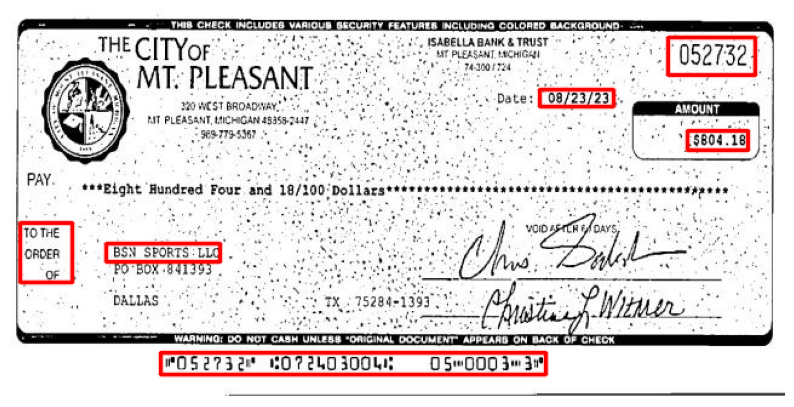

In [43]:
l_roi_dets[-1].draw(all_ds)

In [351]:
save_dets(l_roi_dets, f_roi_dets_sav)

2024-02-20 12:05:14.068 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/roi_dets.h5


In [352]:
l_words_dets = []
for res in tqdm(detect(words_model, all_ds, stream=True),
              total=len(all_ds)):
    l_words_dets.append(res)

2024-02-20 12:05:22.970 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: True
2024-02-20 12:05:22.971 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-20 12:05:22.972 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 235 samples


  0%|          | 0/235 [00:00<?, ?it/s]

In [362]:
for words_dets in tqdm(l_words_dets):
    temp_ds = words_dets.create_ds(all_ds)
    temp_ds.batched = True
    l_recs = recognize(rec_model, temp_ds, stream=False, verbose=False)
    _ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, l_recs)]

  0%|          | 0/235 [00:00<?, ?it/s]

In [363]:
save_dets(l_words_dets, f_words_dets_sav)

2024-02-20 13:14:17.488 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/words_dets.h5


In [459]:
l_gcv_dets = []
for res in tqdm(detect(gcv_model, all_ds, stream=True),
              total=len(all_ds)):
    l_gcv_dets.append(res)

Reloading 'chequeparser.models.detection.gcv'.


2024-02-20 13:45:34.918 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: True
2024-02-20 13:45:34.919 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-20 13:45:34.919 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 235 samples


  0%|          | 0/235 [00:00<?, ?it/s]

In [461]:
save_dets(l_gcv_dets, f_gcv_dets_sav)

2024-02-20 13:51:37.238 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/gcv_dets.h5


## load dets

In [384]:
l_roi_dets = load_dets(f_roi_dets_sav)

In [44]:
l_words_dets = load_dets(f_words_dets_sav)

In [22]:
l_gcv_dets = load_dets(f_gcv_dets_sav)

In [23]:
len(l_gcv_dets), len(l_roi_dets)

(235, 235)

In [416]:
save_dets_as_label_studio(l_roi_dets, "temp/pre-annots.json", subdir_images="chequeparser/data/public/images")

Reloading 'chequeparser.utilities.io_utils'.


## extract features

### anchor features

In [367]:
l_anchor_roi_dets = [roi_dets.filter_by_labels(["orderof"], split=True)[0]
                     for roi_dets in l_roi_dets]

In [368]:
l_left_half_anchor_rois = [anchor_roi_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for anchor_roi_dets in l_anchor_roi_dets]
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for words_dets in l_words_dets]

In [369]:
l_words_inside_rois = [[
                        l_h_w_dets.filter_by_bbox(bbox, thresh=0.7)
                        for bbox in l_h_a_rois.bboxes]
                       for l_h_w_dets, l_h_a_rois in zip(l_left_half_words_dets,
                                                         l_left_half_anchor_rois)
                      ]

In [370]:
l_anchor_scores = [[sum([1 if keyword in bbox.text.lower() else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes])
                 for dets in words_inside_rois]
                for words_inside_rois in l_words_inside_rois]

In [371]:
l_selected_anchor_ids = [max(range(len(anchor_scores)), 
                             key=lambda x : anchor_scores[x])
                         if len(anchor_scores) > 0 else None
                         for anchor_scores in l_anchor_scores]


In [372]:
l_selected_anchor_rois = [rois.filter_by_idxs([idx])
                          if idx is not None else rois.empty()
                          for idx, rois in zip(l_selected_anchor_ids, 
                                               l_left_half_anchor_rois)]


In [373]:
l_spell_corr_left_half_words_dets = [
    left_half_words_dets.empty() for left_half_words_dets
    in l_left_half_words_dets]

In [374]:
for lh_dets, spell_dets in zip(l_left_half_words_dets,
                               l_spell_corr_left_half_words_dets):
    spell_dets.bboxes = [
        box.apply_text_op(op_spell_check, lowercase=True)
        for box in lh_dets.bboxes
    ]

In [375]:
l_bkp_anchor_dets = [
    dets.filter_by_bbox_text("order").filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

In [391]:
l_bkp2_anchor_dets = [
    dets.filter_by_bbox_text("pay", True).filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

Reloading 'chequeparser.wrappers.detection_results'.


In [142]:
l_bkp2_anchor_dets[3].draw(all_ds)

NameError: name 'l_bkp2_anchor_dets' is not defined

In [405]:
save_dets(l_selected_anchor_rois, f_true_anchor_dets_sav)

2024-02-20 13:27:03.852 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/true_anchor_dets.h5


In [406]:
save_dets(l_bkp_anchor_dets, f_bkp_anchor_dets_sav)
save_dets(l_bkp2_anchor_dets, f_bkp2_anchor_dets_sav)

2024-02-20 13:27:04.739 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/bkp_anchor_dets.h5
2024-02-20 13:27:04.792 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/bkp2_anchor_dets.h5


In [362]:
all_a_boxes = np.array([dets.to_numpy(encode=False, normalize=True)[..., :4] for dets in true_anchors if len(dets) > 0 ])

In [371]:
np.mean(all_a_boxes.astype(np.float32), axis=0)

Reloading 'chequeparser.wrappers.detection_results'.


array([[   0.037235,     0.33455,     0.11651,     0.41156]], dtype=float32)

## true payee features

In [27]:
l_payee_roi_dets = [roi_dets.filter_by_labels(["payee"], split=True)[0]
                     for roi_dets in l_roi_dets]

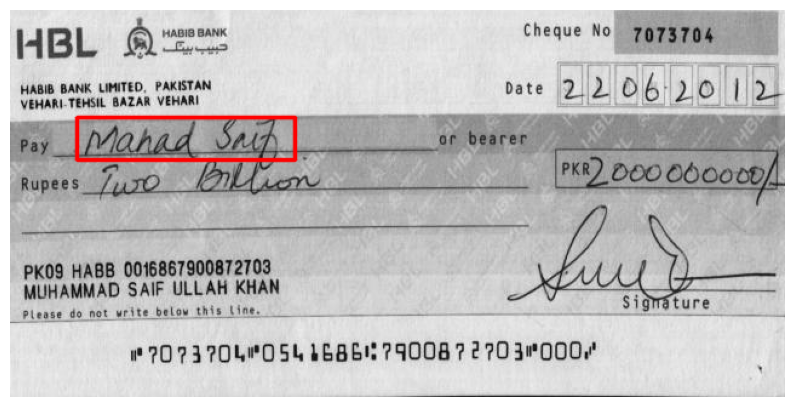

In [28]:
l_payee_roi_dets[10].draw(all_ds)

In [412]:
l_eligible_payee_rois = [payee_roi_dets.filter_by_conf(0.6)
                         for payee_roi_dets in l_payee_roi_dets]

In [29]:
l_high_conf_payee_rois = [payee_roi_dets.filter_by_conf(0.89).filter_by_labels(labels=["payee"],
                                                                              only_max_conf=True,
                                                                              split=False)
                         for payee_roi_dets in l_payee_roi_dets]

In [464]:
l_words_inside_h_c_p_rois = [
    words_dets.filter_by_bbox(dets.bboxes[0]).sort_bboxes_lr().group_bboxes() if len(dets) > 0
    else words_dets.empty()
    for words_dets, dets in zip(l_gcv_dets, l_high_conf_payee_rois)
]

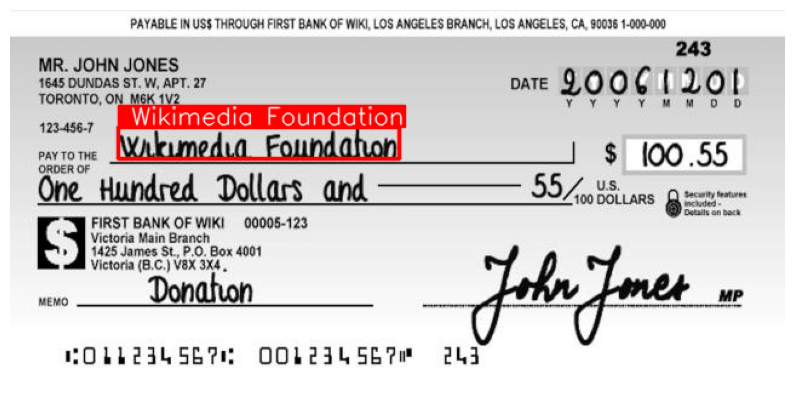

In [477]:
l_words_inside_h_c_p_rois[99].draw(all_ds, show_text=True)

In [479]:
save_dets(l_words_inside_h_c_p_rois, f_true_payee_dets_sav)

2024-02-20 15:16:23.496 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/true_payee_dets.h5


## false payee feature

In [24]:
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.6, 0.9)
                           for words_dets in l_gcv_dets]

In [30]:
l_l_h_w_not_inside_roi_dets = [
    words_dets.filter_by_bbox(dets.bboxes[0], inside=False).sort_bboxes_lr().group_bboxes(detect_lines=True)
    if len(dets) > 0 else words_dets.empty()
    for words_dets, dets in zip(l_left_half_words_dets, l_high_conf_payee_rois)
]

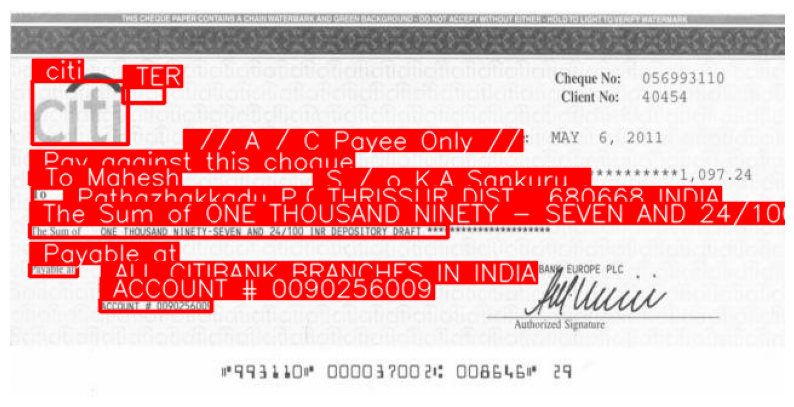

In [40]:
l_l_h_w_not_inside_roi_dets[0].draw(all_ds, show_text=True)

In [32]:
save_dets(l_l_h_w_not_inside_roi_dets, f_false_payee_dets_sav)

2024-02-20 17:20:18.227 | INFO     | chequeparser.utilities.io_utils:save_dets:72 - Detections saved to temp/false_payee_dets.h5


## creating df for text clf

In [81]:
import pandas as pd

In [33]:
true_anchors = load_dets(f_true_anchor_dets_sav)

In [34]:
true_payees = load_dets(f_true_payee_dets_sav)

In [207]:
bkp_anchors = load_dets(f_bkp_anchor_dets_sav)

In [208]:
bkp2_anchors = load_dets(f_bkp2_anchor_dets_sav)

In [209]:
false_payees = load_dets(f_false_payee_dets_sav)

### creating true rows

In [279]:
def merge_(anchor_, payee_):
    anchor_ = anchor_.astype(np.float32)
    payee_box_ = payee_[:4].astype(np.float32)
    payee_text_ = payee_[-1]
    anchor_noisy = anchor_ + np.random.uniform(-1e-4, 1e-4, size=anchor_.shape)
    payee_noisy = payee_box_ + np.random.uniform(-1e-4, 1e-4, size=payee_box_.shape)
    return anchor_noisy.tolist() + payee_noisy.tolist() + [payee_text_]

In [280]:
l_true_rows = []
idx = 0

for t_anchor, b_anchor, b2_anchor, t_payee in zip(true_anchors,
                                                  bkp_anchors,
                                                  bkp2_anchors,
                                                  true_payees):
    if len(t_payee) == 0:
        idx += 1
        continue
    payee_data = [t_payee[0].normalize(t_payee.width, t_payee.height).to_numpy(encode=False)[[0, 1, 2, 3, -2]]]
    anchor_data = []
    if len(t_anchor) > 0:
        anchor_data += [t_anchor[0].normalize(t_anchor.width, t_anchor.height).to_numpy(encode=False)[:4]]
    if len(b_anchor) > 0:
        anchor_data += [b_anchor[0].normalize(b_anchor.width, b_anchor.height).to_numpy(encode=False)[:4]]
    if len(b2_anchor) > 0:
        anchor_data += [b2_anchor[0].normalize(b2_anchor.width, b2_anchor.height).to_numpy(encode=False)[:4]]
    
    products = list( [idx] + merge_(x, y)
                    for x, y in product(anchor_data, payee_data))
    l_true_rows += products
    idx += 1

In [281]:
true_df = pd.DataFrame(l_true_rows, columns=["idx", "anchor_x1", "anchor_y1", "anchor_x2", "anchor_y2",
                                             "payee_x1", "payee_y1", "payee_x2", "payee_y2",
                                             "payee_txt"])

In [282]:
text_col = "payee_txt"

In [283]:
col_dtypes = {k: 'float32' if k != text_col else 'object' for k in true_df.columns}

In [284]:
true_df = true_df.astype({**col_dtypes, "idx": "int32"})

In [285]:
true_df["target"] = 1

In [291]:
true_df.head()

,idx,anchor_x1,anchor_y1,anchor_x2,anchor_y2,payee_x1,payee_y1,payee_x2,payee_y2,payee_txt,target
0,0,0.020364,0.640630,0.085902,0.700059,0.117104,0.656325,0.240542,0.684436,PAYABLE AT PAR AT,1
1,1,0.031160,0.568830,0.089152,0.728088,0.156285,0.568843,0.289002,0.606338,BSN SPORTS LLC,1
2,1,0.031277,0.653077,0.081291,0.687494,0.156311,0.568844,0.288997,0.606274,BSN SPORTS LLC,1
3,1,0.028213,0.574966,0.062599,0.615623,0.156257,0.568692,0.289121,0.606166,BSN SPORTS LLC,1
4,2,0.031220,0.221854,0.084424,0.281200,0.321910,0.206174,0.662580,0.287516,P. Shiv Kumar Roy .,1


In [335]:
unique_ids = true_df["idx"].unique().tolist()

In [336]:
test_samples, _ = get_samples(unique_ids, k= int(0.2 * len(unique_ids)))

In [337]:
test_true_df = true_df.loc[true_df["idx"].isin(test_samples)].reset_index(drop=True)

In [338]:
train_true_df = true_df.loc[~true_df["idx"].isin(test_samples)].reset_index(drop=True)

### creating false rows

In [321]:
l_false_rows = []
idx = 0
for t_anchor, b_anchor, b2_anchor, f_payee in zip(true_anchors,
                                                  bkp_anchors,
                                                  bkp2_anchors,
                                                  false_payees):
    if len(t_payee) == 0:
        idx += 1
        continue
    payee_data = [bbox.normalize(f_payee.width, f_payee.height).to_numpy(encode=False)[[0,1,2,3,-2]]
                  for bbox in f_payee.sample(k=3)]
    
    anchor_data = []
    if len(t_anchor) > 0:
        anchor_data += [t_anchor[0].normalize(t_anchor.width, t_anchor.height).to_numpy(encode=False)[:4]]
    if len(b_anchor) > 0:
        anchor_data += [b_anchor[0].normalize(b_anchor.width, b_anchor.height).to_numpy(encode=False)[:4]]
    if len(b2_anchor) > 0:
        anchor_data += [b2_anchor[0].normalize(b2_anchor.width, b2_anchor.height).to_numpy(encode=False)[:4]]
        
    products = list([idx] + merge_(x, y) for x, y in product(anchor_data, payee_data))
    l_false_rows += products
    idx += 1

In [322]:
false_df = pd.DataFrame(l_false_rows, columns=["idx", "anchor_x1", "anchor_y1", "anchor_x2", "anchor_y2",
                                               "payee_x1", "payee_y1", "payee_x2", "payee_y2",
                                               "payee_txt"])

In [323]:
false_df = false_df.astype({**col_dtypes, "idx": "int32"})

In [324]:
false_df["target"] = 0

In [328]:
false_df.head()

,idx,anchor_x1,anchor_y1,anchor_x2,anchor_y2,payee_x1,payee_y1,payee_x2,payee_y2,payee_txt,target
0,0,0.020389,0.640581,0.085925,0.699902,0.390613,0.465622,0.506256,0.496925,"S / o K.A Sankuru ,",0
1,0,0.020254,0.640569,0.086011,0.700067,0.028190,0.459419,0.112470,0.496807,To Mahesh,0
2,0,0.020377,0.640657,0.085889,0.700011,0.145363,0.199905,0.198478,0.240654,TER,0
3,1,0.031181,0.568791,0.088981,0.728208,0.031265,0.656234,0.078063,0.681261,ORDER,0
4,1,0.031191,0.568827,0.089146,0.728214,0.171870,0.146962,0.335908,0.178101,WESTSIDE HIGH SCHOOL,0


In [339]:
unique_ids2 = false_df["idx"].unique().tolist()

In [340]:
test_samples2, _ = get_samples(unique_ids2, k= int(0.2 * len(unique_ids2)))

In [341]:
test_false_df = false_df.loc[false_df["idx"].isin(test_samples2)].reset_index(drop=True)

In [342]:
train_false_df = false_df.loc[~false_df["idx"].isin(test_samples2)].reset_index(drop=True)

In [346]:
merged_train_df = pd.concat([train_true_df, train_false_df], axis="rows", ignore_index=True)

In [347]:
merged_test_df = pd.concat([test_true_df, test_false_df], axis="rows", ignore_index=True)

In [348]:
merged_train_df.to_csv("temp/merged_train.csv", index=False)

In [349]:
merged_test_df.to_csv("temp/merged_test.csv", index=False)